### [Sequence Models](https://youtu.be/S7oA5C43Rbc?si=e_6chxscLpNwXvBX)

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# df = pd.read_csv('temp.csv')
# data = torch.tensor(df['Temperature (C)'].values, dtype=torch.float32)
# data.shape

In [ ]:
import torch
import torch.nn as nn

class MultivariateRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MultivariateRNN, self).__init__()

        # input_size=2 (Temp, Wind)
        # hidden_size=3 (3 internal neurons)
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True)

    def forward(self, x):
        out, hn = self.rnn(x)
        return out, hn

# 1. Instantiate the model
# input_size is now 2!
model = MultivariateRNN(input_size=2, hidden_size=3)

# 2. Prepare the Input Data
# We need 2 numbers for every time step.
# Let's say:
#   Time t=1: Temp=20, Wind=5
#   Time t=2: Temp=22, Wind=3
#   Time t=3: Temp=19, Wind=8

input_data = torch.tensor([
    [
        [20.0, 5.0],  # Step 1
        [22.0, 3.0],  # Step 2
        [19.0, 8.0]   # Step 3
    ]
])

# Shape Check:
# (Batch_Size=1, Sequence_Length=3, Input_Features=2)
print(f"Input shape: {input_data.shape}")

# 3. Forward pass
output, final_hidden = model(input_data)

print("\nFinal Hidden State (The memory after seeing all 3 steps):")
print(final_hidden)
# This will be shape (1, 1, 3) because we have 3 hidden neurons.

Input shape: torch.Size([1, 3, 2])

Final Hidden State (The memory after seeing all 3 steps):
tensor([[[ 1.0000, -1.0000,  1.0000]]], grad_fn=<StackBackward0>)


In [ ]:
N = 10
x = torch.zeros((1,2))
W = torch.ones((N, 2))

a = np.dot(x, W)
a.shape

C:\Users\APC\AppData\Local\Temp\ipykernel_24376\319673336.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.dot(x, W)


ValueError: shapes (1,1) and (10,1) not aligned: 1 (dim 1) != 10 (dim 0)

In [ ]:
data = data.view(-1, 1) # add 1 dimension y
data.shape

### RNN Model
batch - sequence_length - features

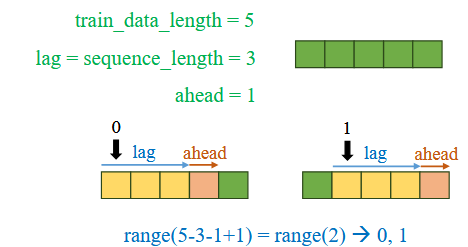

In [ ]:
def create_sequence(data, lag=3, ahead=1):
    #? Choose number of input sample:prediction ratio. 3:1 mean every sample use sequence of 3 to predict 1 datapoint
    X, y = [], []
    for i in range(len(data) - lag - ahead + 1):
        X.append(data[i: i+lag]) # number of sample each sequence
        y.append(data[i+lag: i+lag+ahead]) # number of future prediction

    return np.array(X), np.array(y)

sequence = create_sequence(data)

print("X shape:", sequence[0].shape) # (count, row, col)
print("y shape:", sequence[1].shape) # (count, row, col)

In [ ]:
def prepare_data(data, lag, ahead, batch_size, train_ratio=0.7):
    X, y = create_sequence(data, lag, ahead)

    train_size = int(len(data) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # load train and test seperately
    return train_loader, X_test_tensor, y_test_tensor


In [ ]:
train_loader, _, _ = prepare_data(data, lag=5, ahead=1, batch_size=12, train_ratio=0.7)
# print(X_test_tensor[0].shape)

In [ ]:
m = torch.zeros((2,2))
print(m, "\n")
n = m.view(-1, 2) # flatten
print(n)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (sequences, labels) in enumerate(train_loader):
            # Forward pass
            print('SHAPE:', sequences.shape)
            outputs = model(sequences) #!
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad() # clear all gradient in this iter, Prevent gradient accumulation
            loss.backward() # backpropagation
            optimizer.step() # update

            running_loss+=loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(running_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss {epoch_loss:.4f}")

    return model, losses


def evaluate_model(model, X_test_tensor, y_test_tensor,ahead):
    # Switch into evaluation model (switch to testing module)
    # ensure dropout, batchnorm, and gradient behave correctly
    model.eval()

    with torch.no_grad(): # turn off gradient Tracking, reduce memory usage
        pred = model(X_test_tensor)
        #? view() reshape tensor without copy&paste them into new shape molt
        pred = pred.view(-1, ahead).numpy() # reshape prediction (row, col) where -1 mean all
        y_test = y_test_tensor.numpy()
        print(f'{pred.shape}')
        print(f'{y_test.shape}')

        r2 = r2_score(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        mse = mean_absolute_error(y_test, pred)

    print(f'R2 Score {r2}')
    print(f'MSE Score {mse}')
    print(f'MAE Score {mae}')

    return r2, mse, mae


def plot_training_loss(losses):
    plt.plot(losses, label="training losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
num_epochs = 20
train_ratio = 0.8
batch_size = 64
lr = 0.001
lag = 10
ahead = 1
hidden_dim = 32

In [ ]:
# initia model
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output_rnn, hidden_rnn = self.rnn(x)
        last_hidden = hidden_rnn[-1, :, :] # flatten
        output = self.fc(last_hidden)

        return output

In [ ]:
# preapare data
train_loader, X_test_tensor, y_test_tensor = prepare_data(data, lag, ahead, batch_size, train_ratio=0.7)

# train model
model = RNNModel(hidden_dim=2, output_dim=1)
model

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model, losses = train_model(model, criterion, optimizer, train_loader, num_epochs=20)

In [ ]:
plot_training_loss(losses)